In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from helpers import Domain 
from load_data import get_fit_params_from_pdbshot, load_single_pulse_struct, PulseStruct, KineticProfileStruct, SignalStruct
import pickle
from dataclasses import dataclass 


In [2]:
LOCAL_SAVE_DIR = "/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs"
JET_PDB_DIR    = "/scratch/project_2009007/stability_fun/data" 
BASE_PULSE_DIR = JET_PDB_DIR

In [3]:
@dataclass 
class Result: 
    all_ne: np.ndarray 
    all_te: np.ndarray 
    all_pe: np.ndarray 
    all_times: np.ndarray 
    all_alpha: np.ndarray
    xdomain: Domain 

def load_result(savedir: str) -> Result: 
    all_ne = np.load(os.path.join(savedir, "ne.npy"))
    all_te = np.load(os.path.join(savedir, "te.npy"))
    all_pe = np.load(os.path.join(savedir, "pe.npy"))
    all_times = np.load(os.path.join(savedir, "times.npy"))
    with open(os.path.join(savedir, 'domain.pickle'), 'rb') as file: 
        xdomain = pickle.load(file)

    in_ped = xdomain.phi_norm > 0.93
    all_alpha = np.max(abs(np.gradient(all_pe[:, in_ped], xdomain.phi_norm[in_ped], axis=1)), axis=1)


    return Result(all_ne, all_te, all_pe, all_times, all_alpha, xdomain)

In [19]:
shot_num = 83624

if shot_num == 83630: 
    ALPHA_CRIT = 114.7
    expected_exp = 0.0442
elif shot_num == 83625: 
    ALPHA_CRIT = 110.0
elif shot_num == 83628:
    ALPHA_CRIT = 101.7 
    expected_exp = 0.029
elif shot_num == 83624: 
    ALPHA_CRIT = 95.46
    expected_exp = 0.02792
else: 
    ALPHA_CRIT = 100.0
    expected_exp = 0.3
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

savedir = os.path.join(os.path.join(LOCAL_SAVE_DIR, f'{shot_num}'))
fixed_res = load_result(savedir)
probablistic_dirs = [os.path.join(savedir, _dir) for _dir in os.listdir(savedir) if 'probabilistic' in _dir]

print(probablistic_dirs)
# savedir = os.path.join(savedir, 'probabilistic')
# savedir = "/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83628/probabilistic_2241206299"
savedir = probablistic_dirs[0]
prob_res_many = []
for savedir in probablistic_dirs: 
    prob_res = load_result(savedir)
    prob_res_many.append(prob_res)



te_fit_params, ne_fit_params, pe_fit_params, machineparams  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)


['/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83624/probabilistic_2923688075', '/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83624/probabilistic_3679091204', '/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83624/probabilistic_2907440424', '/scratch/project_2009007/stability_fun/trans_shenanigans/models/data_driven/outputs/83624/probabilistic_4230747973']


In [16]:
te_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (te_fit_params.p - te_fit_params.w)))
ne_ped_idx = np.argmin(abs(fixed_res.xdomain.phi_norm - (ne_fit_params.p - ne_fit_params.w)))

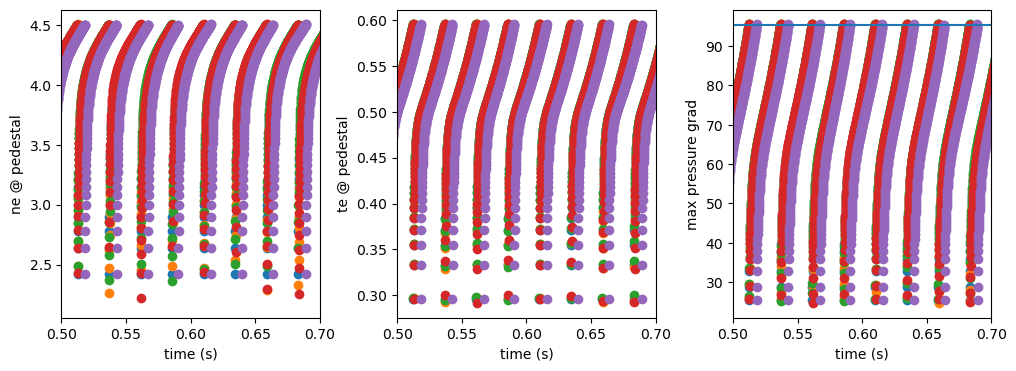

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(fixed_res.all_times, fixed_res.all_ne[:, ne_ped_idx], label='Fixed C_GROWTH/C_CRASH')
axs[1].scatter(fixed_res.all_times, fixed_res.all_te[:, te_ped_idx])
axs[2].scatter(fixed_res.all_times, fixed_res.all_alpha)
for n, prob_res in enumerate(prob_res_many):
    axs[0].scatter(prob_res.all_times, prob_res.all_ne[:, ne_ped_idx], label='Sampled at ELM Crash')
    axs[1].scatter(prob_res.all_times, prob_res.all_te[:, te_ped_idx])
    axs[2].scatter(prob_res.all_times, prob_res.all_alpha)
# axs[0].legend()
axs[0].set_ylabel('ne @ pedestal')
axs[1].set_ylabel('te @ pedestal')
axs[2].set_ylabel('max pressure grad')
for ax in axs: 
    ax.set_xlabel('time (s)')
    ax.set_xlim(0.5, 0.7)
axs[2].axhline(ALPHA_CRIT)
fig.subplots_adjust(wspace=0.3)
plt.show()

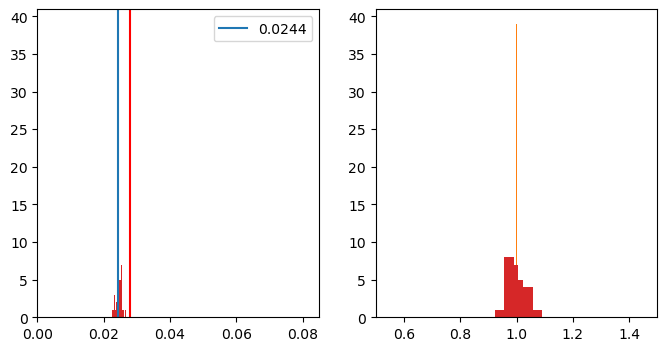

In [26]:
def get_tau_interelms(res: Result) -> np.ndarray: 
    elm_events = res.all_alpha >= ALPHA_CRIT
    elm_times  = res.all_times[elm_events]
    tau_interelms = np.empty(len(elm_times) -1)
    for i in range(len(elm_times)-1): 
        tau_interelms[i] = elm_times[i+1] - elm_times[i]
    return tau_interelms

prob_res = prob_res_many[1]

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

tau_interelms_all = []
for prob_res in prob_res_many: 
    TAU_INTERELM = get_tau_interelms(prob_res)
    axs[0].hist(TAU_INTERELM, bins=15)
    frequencies = 1.0 / TAU_INTERELM
    axs[1].hist(frequencies / np.mean(frequencies))
    tau_interelms_all.append(TAU_INTERELM)

FIXED_TAU_INTERELM = get_tau_interelms(fixed_res)
axs[0].axvline(FIXED_TAU_INTERELM.mean(), label=f'{FIXED_TAU_INTERELM.mean():.4}')
axs[0].axvline(expected_exp, color='red')
axs[0].set_xlim(0.0, 0.085)
axs[0].legend()
axs[1].set_xlim(0.5, 1.5)
# print((prob_res.all_alpha >= ALPHA_CRIT).sum())
plt.show()


In [ ]:

fig, axs = plt.subplots() 


    